In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.preprocessing import scale
from sklearn.manifold import Isomap, TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from utilities import *
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
qc_17302 = load_features_as_one(['data/QC/17302_Thalamuscells.QC.txt',])
qc_17302 = qc_17302.rename({"Percentage_lost(%)":"Percentage_unconnected(%)"}, axis='columns')
for i in range(len(qc_17302)):
    qc_17302 = qc_17302.rename({qc_17302.index[i]:("17302_"+qc_17302.index[i])}, axis='rows')
qc_17302['Type'] = pd.Categorical(qc_17302['Type'])

ddt_17302 = load_features_as_one(['data/features/17302_Thalamuscells.dendrite.features'], drop_attr=["Soma Surface"])
ddt_17302 = ddt_17302.drop(ddt_17302[ddt_17302['Number of Nodes']<1000].index, axis=0)
for i in range(len(ddt_17302)):
    ddt_17302 = ddt_17302.rename({ddt_17302.index[i]:("17302_"+ddt_17302.index[i])}, axis='rows')

sel_id = qc_17302.index[qc_17302["Percentage_unconnected(%)"]<10]
sel_id = [i for i in sel_id if i in ddt_17302.index.tolist()]
ddt_17302 = ddt_17302.loc[sel_id]

In [15]:
qc_17545 = load_features_as_one(['data/QC/17545_Thalamuscells.QC.txt',])
qc_17545 = qc_17545.rename({"Percentage_lost(%)":"Percentage_unconnected(%)"}, axis='columns')
for i in range(len(qc_17545)):
    qc_17545 = qc_17545.rename({qc_17545.index[i]:("17545_"+qc_17545.index[i])}, axis='rows')
qc_17545['Type'] = pd.Categorical(qc_17545['Type'])

ddt_17545 = load_features_as_one(['data/features/17545_Thalamuscells.dendrite.features'], drop_attr=["Soma Surface"])
ddt_17545 = ddt_17545.drop(ddt_17545[ddt_17545['Number of Nodes']<1000].index, axis=0)
for i in range(len(ddt_17545)):
    ddt_17545 = ddt_17545.rename({ddt_17545.index[i]:("17545_"+ddt_17545.index[i])}, axis='rows')

sel_id = qc_17545.index[qc_17545["Percentage_unconnected(%)"]<10]
sel_id = [i for i in sel_id if i in ddt_17545.index.tolist()]
ddt_17545 = ddt_17545.loc[sel_id]

In [16]:
qc = pd.concat([qc_17302, qc_17545])
ddt = pd.concat([ddt_17302, ddt_17545])
brain_id = pd.DataFrame(["17302"]*len(ddt_17302)+["17545"]*len(ddt_17545), index=ddt.index, columns=["Type"])

# Cell types
# celltypes = pd.DataFrame(ddt['Type'])
celltypes = pd.DataFrame(brain_id['Type'])
celltypes['Type']=pd.Categorical(celltypes['Type'])
u_celltypes = list(set(celltypes['Type']))

my_pal = ['C'+str(i) for i in range(len(u_celltypes))]
lut = dict(zip(sorted(u_celltypes), my_pal))
colors = []
for tp in celltypes['Type'].tolist():
    colors.append(lut[tp])

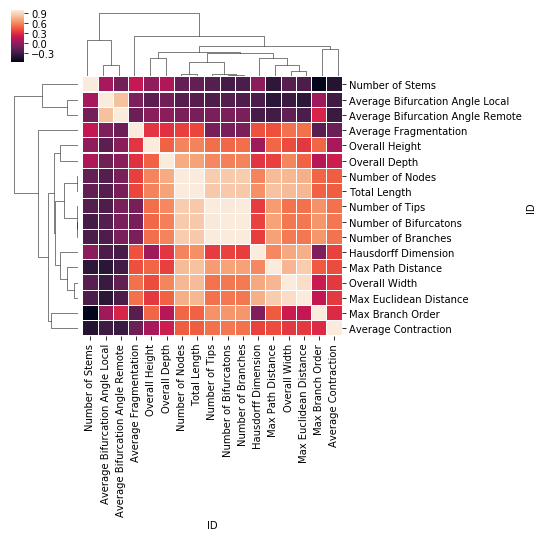

In [24]:
df = ddt.iloc[:, 1:]
df = df.drop(["Average Diameter", "Total Surface", "Total Volume", "Average Parent-daughter Ratio"],
             axis=1)
df = pd.DataFrame(scale(df), columns=df.columns, index=df.index.tolist())


corr_feature = df.corr(method='spearman')
_ = sns.clustermap(corr_feature, linewidths=0.1, vmax=1.0, square=True, linecolor='white', annot=False, figsize=(6,6))


Running Isomap...
Running tSNE...


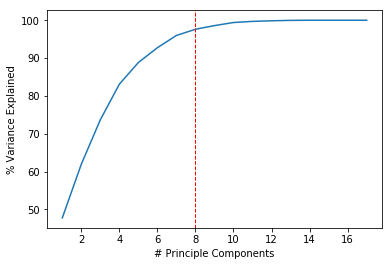

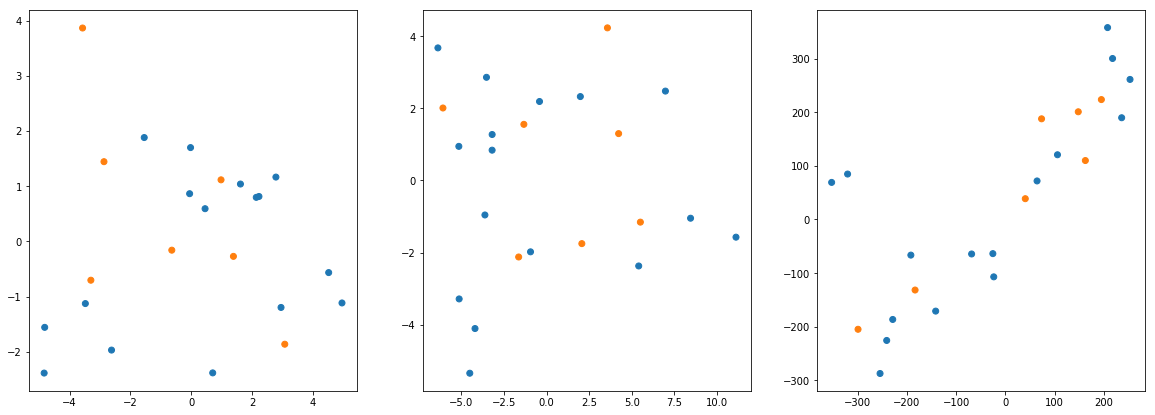

In [25]:
# Create a regular PCA model 
pca = PCA(n_components=df.shape[1])
# Fit and transform the data to the model
reduced_data_pca = pca.fit_transform(df)

use_pcs = 8
tp = np.cumsum(pca.explained_variance_ratio_)*100
plt.plot(range(1, len(tp)+1), tp)
plt.xlabel('# Principle Components')
plt.ylabel('% Variance Explained')
plt.axvline(use_pcs, c='r', lw=1, ls='dashed')


# Fit and transform the data to the model
reduced_data_pca = reduced_data_pca[:,:use_pcs]

fig, ax = plt.subplots(1,3, figsize=(20, 7))

# PCA
ax[0].scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], c=colors)

# Isomap
print('Running Isomap...')
isomap = Isomap(n_neighbors=4)
X_iso = isomap.fit_transform(reduced_data_pca)
ax[1].scatter(X_iso[:, 0], X_iso[:, 1], c=colors)

# tSNE
print('Running tSNE...')
tsne = TSNE(n_components=2, perplexity=3)
X_tsne = tsne.fit_transform(reduced_data_pca)
ax[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors)

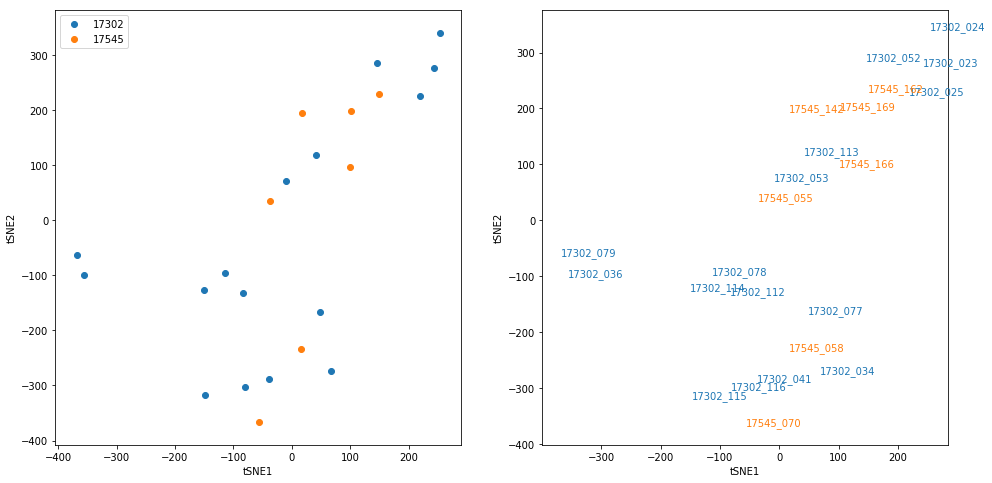

In [26]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
tsne = TSNE(n_components=2, perplexity=3)
X_tsne = tsne.fit_transform(reduced_data_pca)

X_plot = X_tsne

ax[0].scatter(X_plot[:, 0], X_plot[:, 1], c='w')
for ct in u_celltypes:
    lab = (celltypes['Type']==ct)
    ax[0].scatter(X_plot[lab, 0], X_plot[lab, 1], c=lut[ct], label=ct)
ax[0].legend()
ax[0].set_xlabel('tSNE1')
ax[0].set_ylabel('tSNE2')


ax[1].scatter(X_plot[:, 0], X_plot[:, 1], c='w')
for ct in u_celltypes:
    lab = [i for i in range(len(celltypes)) if (celltypes['Type'][i]==ct)] 
    for i in lab:
        ax[1].text(X_plot[i, 0], X_plot[i, 1], df.index[i], {'color':lut[ct]})
ax[1].set_xlabel('tSNE1')
ax[1].set_ylabel('tSNE2')

fig.savefig("Figure/Thalamuscells_combined_tSNE.ddt.pdf")

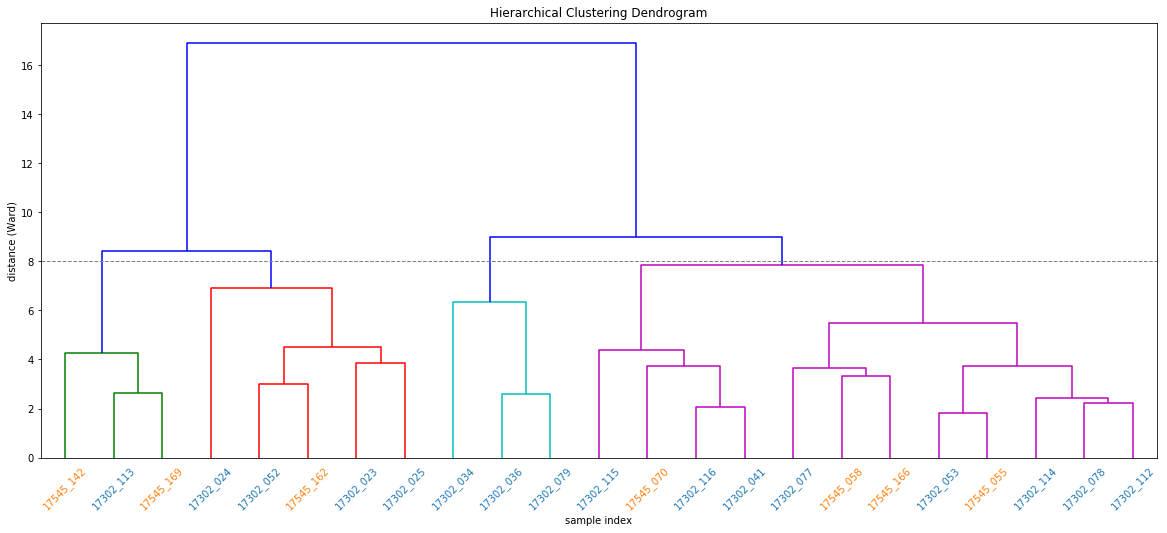

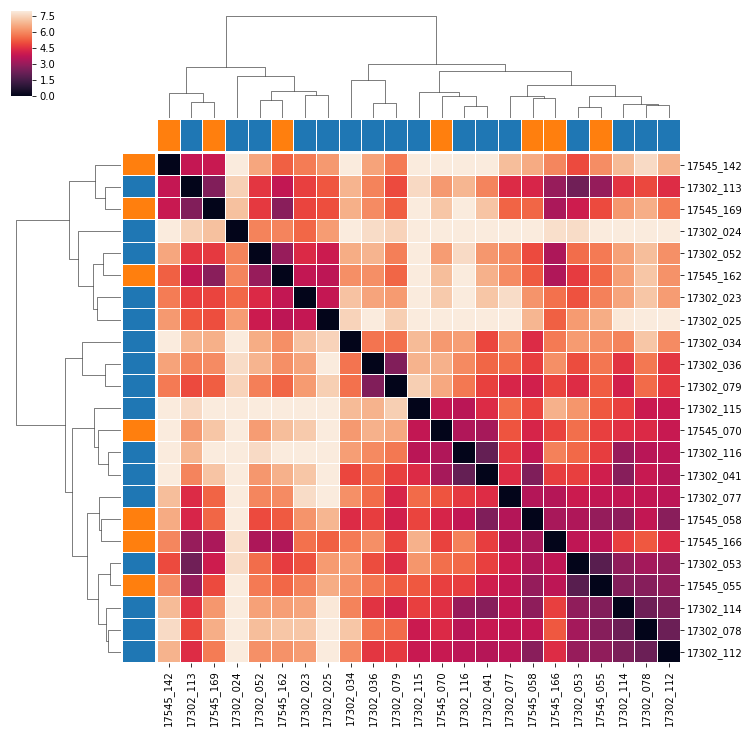

In [29]:
Z = linkage(df, 'ward')

thres = 8
fig, ax = plt.subplots(1,1,figsize=(20,8))
d = dendrogram(Z, labels=df.index, leaf_rotation=45, leaf_font_size=10,
               color_threshold=thres, orientation="top",
              )
plt.axhline(y=thres, c='grey', lw=1, linestyle='dashed')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')
fig.savefig("Figure/Thalamuscells_combined_dendrogram.ddt.pdf")

# transforme the 'cyl' column in a categorical variable. It will allow to put one color on each level.
my_color=celltypes.loc[d['ivl'], 'Type'].cat.codes
 
# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    lbl.set_color(my_pal[my_color[num]])
    
clusters = pd.DataFrame({'cluster':fcluster(Z, thres, criterion="distance")}, index=df.index)

# corr_cell = pd.DataFrame(reduced_data_pca, index=df.index).transpose().corr(method='pearson')

dist = squareform(pdist(df))
dist = pd.DataFrame(dist, index=df.index, columns=df.index)

g = sns.clustermap(dist, linewidths=0.01, vmax=thres, linecolor='white', 
                   row_colors=colors, col_colors=colors, 
                   row_linkage=Z, col_linkage=Z,
                   annot=False, figsize=(12,12))
g.savefig("Figure/Thalamuscells_combined_heatmap.ddt.pdf")


In [34]:
# ano file for each cluster
u_clusters = list(set(clusters['cluster']))
lab = clusters.loc[g.data2d.columns, "cluster"]
# f = open('data/Thalamuscells.ddt.clusters.ano', 'w')
f = open('data/Thalamuscells.lpa.clusters.ano', 'w')
for i in u_clusters:  
    tp = g.data2d.columns[lab==i].tolist()    
    for j in tp:
        j = j.split("_")
        j = ("_").join([j[0], "Thalamuscells", j[1]])
#         f.write(("SWCFILE=processed_swc/Dendrite/"+j+".processed.dendrite.cropped.swc\n"))
        f.write(("SWCFILE=processed_swc/Axon/"+j+".processed.long_axon.swc\n"))
f.close()